In [40]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re
import os

import spacy


import nltk
import nltk.data
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import PorterStemmer

from wordcloud import WordCloud

import preprocessor as p

from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
INFO: Successfully saved requirements file in c:\Users\adriz\Documents\TESINA\requirements.txt


In [2]:
encoding = 'UTF-8'
col_names = ['id', 'fecha', 'tweet']
dataset = pd.read_csv('./data/pre_clean_non_d_tweets.csv', encoding=encoding)

In [3]:
dataset.head()

id         fecha  \
0  1,42476E+18   8/9/21 5:35   
1  1,42474E+18   8/9/21 4:36   
2  1,42474E+18   8/9/21 4:28   
3  1,42473E+18   8/9/21 4:05   
4   1,4245E+18  8/8/21 12:56   

                                               tweet  
0                      tocar pasar ser el nuevo asmr  
1   Hace 12 años llamé a mi papá y me dio un gran...  
2     hay 6500 idiomas pero elijo hablar solo hechos  
3   Hola a todos, pidan un aumento de sueldo hoy....  
4   invierto en 47 nuevas empresas en un año así ...

In [4]:
non_depressive_tweets = dataset.copy().sample(500, random_state=42)
non_depressive_tweets["label"] = 0
non_depressive_tweets = non_depressive_tweets[['tweet', 'label']]
non_depressive_tweets.dropna(inplace=True)
non_depressive_tweets.head()

tweet  label
1647   nos tenemos el uno al otro somos nuestra mejo...      0
1476   de vez en cuando conozco a alguien cuya histo...      0
2111   ser como pequeñas comunidades capaces de crea...      0
3610   a veces asqueroso un beso francés siempre asq...      0
691    Hoy pasé mucho tiempo discutiendo sobre la se...      0

In [5]:
df2 = pd.read_csv('./data/pre_clean_d_tweets.csv', encoding=encoding)
df2.head()




id         fecha  \
0  1,26162E+18  5/16/20 1:45   
1  1,25554E+18  4/29/20 6:42   
2  1,25552E+18  4/29/20 5:48   
3  1,25552E+18  4/29/20 5:47   
4  1,17246E+18  9/13/19 0:52   

                                               tweet  
0   la verdadera razón por la que estás triste te...  
1      mi mayor problema es pensar demasiado en todo  
2   la peor tristeza es la tristeza que tu te ens...  
3   No puedo hacerte entender. No puedo hacer que...  
4   No creo que nadie realmente entienda lo cansa...

In [6]:
depressive_tweets = df2.copy().sample(500, random_state=42)
depressive_tweets["label"] = 1
depressive_tweets = depressive_tweets[['tweet', 'label']]
depressive_tweets.dropna(inplace=True)
depressive_tweets.head()


tweet  label
1241   música alta para cubrir los pensamientos de e...      1
203    extraño la sensación de saber que soy realmen...      1
1260                                   muerte sin dolor      1
1626   tengo tanta botella que ni siquiera quiero ha...      1
1578   lo siento, me voy a perder por unos días dema...      1

In [7]:
tweets_pool = pd.concat([non_depressive_tweets, depressive_tweets])
tweets_pool = tweets_pool.sample(frac=1)


In [8]:
tweets_pool.info()
tweets_pool.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 2314 to 4105
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


tweet  label
2314   yo, por favor, ayúdenme a mí y a mi amigo, no...      0
785    A veces me siento tan vacío y es tan agotador...      1
3158  animo a todos los padres que tienen una hija a...      0
1513   ¿Qué hablarías con el psicólogo organizaciona...      0
1444   uno de esos días en los que solo quiero evita...      1

In [9]:
# Preprocessing

BAD_SYMBOLS_RE = re.compile('[^0-9a-záéíóúñ #+_]')
nlp = spacy.load('es_core_news_sm')

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-záéíóúñ \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('spanish'))
        word_tokens = nlp(tweet)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(str(v) for v in filtered_sentence)
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [10]:

X = clean_tweets([tweet for tweet in tweets_pool['tweet']])


 yo, por favor, ayúdenme a mí y a mi amigo, nos prohibieron debido a un informe masivo de un niño muy genial, en realidad no hacemos nada malo además de tocar instrumentos en la escuela secundaria, por favor ayuda
 yo, por favor, ayúdenme a mí y a mi amigo, nos prohibieron debido a un informe masivo de un niño muy genial, en realidad no hacemos nada malo además de tocar instrumentos en la escuela secundaria, por favor ayuda
 yo, por favor, ayúdenme a mí y a mi amigo, nos prohibieron debido a un informe masivo de un niño muy genial, en realidad no hacemos nada malo además de tocar instrumentos en la escuela secundaria, por favor ayuda
 yo  por favor  ayúdenme a mí y a mi amigo  nos prohibieron debido a un informe masivo de un niño muy genial  en realidad no hacemos nada malo además de tocar instrumentos en la escuela secundaria  por favor ayuda
yo por favor ayúdenme a mí y a mi amigo nos prohibieron debido a un informe masivo de un niño muy genial en realidad no hacemos nada malo además

In [11]:
# Word analysis
dep_tweets = [clean_tweets([t for t in depressive_tweets['tweet']])]
dep_words = ''.join(list(map(str, dep_tweets)))
dep_wc = WordCloud(width=512, height=512, collocations=False, colormap="Blues").generate(dep_words)

 música alta para cubrir los pensamientos de entrar en mi mente
 música alta para cubrir los pensamientos de entrar en mi mente
 música alta para cubrir los pensamientos de entrar en mi mente
 música alta para cubrir los pensamientos de entrar en mi mente
música alta para cubrir los pensamientos de entrar en mi mente
{'tenida', 'suyas', 'hubiésemos', 'hubieron', 'hubisteis', 'habían', 'me', 'tenga', 'estaría', 'eran', 'tenemos', 'estaba', 'teníais', 'fue', 'estará', 'hubieses', 'contra', 'se', 'vosotras', 'sí', 'serían', 'tendríais', 'tendría', 'somos', 'han', 'estaban', 'sentid', 'esa', 'hayas', 'os', 'tu', 'desde', 'nos', 'estuvierais', 'qué', 'ha', 'seremos', 'teniendo', 'tenía', 'como', 'tengáis', 'seríamos', 'una', 'ella', 'es', 'en', 'estoy', 'sería', 'tendrían', 'eres', 'ante', 'esté', 'habido', 'ellas', 'será', 'quienes', 'seamos', 'habría', 'nuestro', 'sentida', 'nuestras', 'tienes', 'hayan', 'no', 'tendrán', 'entre', 'serías', 'el', 'otro', 'tuvieseis', 'tuvo', 'algunos', 'te

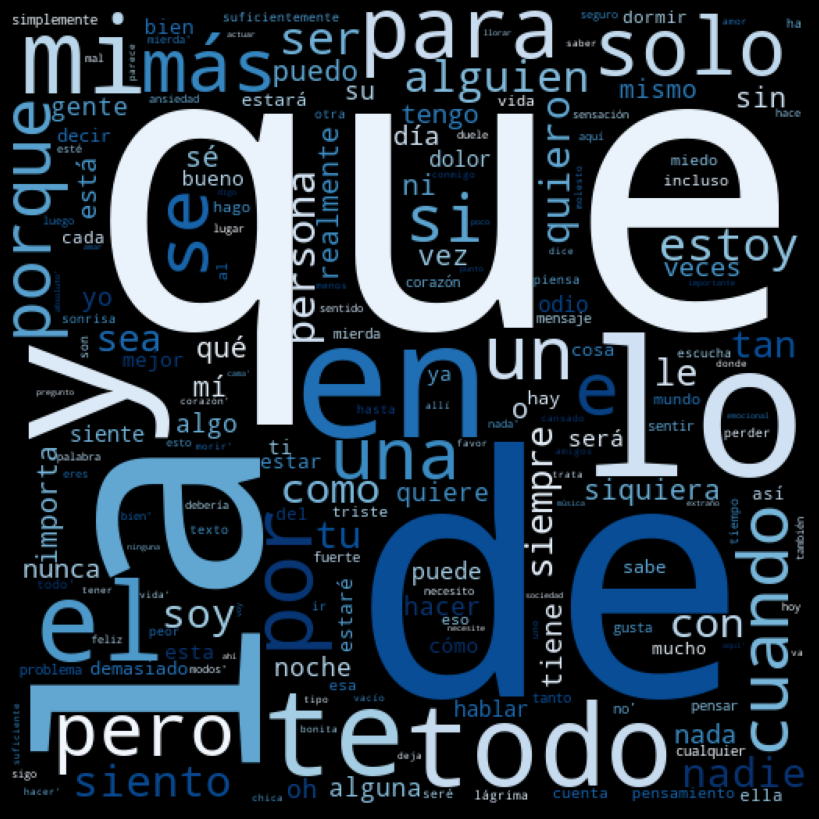

In [12]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(dep_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [13]:
# Tokenization
MAX_NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

In [14]:
word_vector = tokenizer.texts_to_sequences(X)


In [15]:
word_index = tokenizer.word_index


In [16]:
vocabulary_size = len(word_index)
vocabulary_size

3508

In [17]:
MAX_SEQ_LENGTH = 250
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)

In [18]:
input_tensor.shape
print(input_tensor)

[[   0    0    0 ...   13  148  576]
 [   0    0    0 ...   40   42   75]
 [   0    0    0 ...    1   16  448]
 ...
 [   0    0    0 ...   45   54  307]
 [   0    0    0 ... 3501    1 3502]
 [   0    0    0 ...  543   10 3508]]


In [19]:
# Baseline Model 
# TF-IDF Classifier

corpus = tweets_pool['tweet'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS)
tdidf_tensor = tfidf.fit_transform(corpus)

In [20]:
tdidf_tensor.shape

(1000, 3490)

In [21]:
# Training
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, tweets_pool['label'].values, test_size = 0.3)

In [22]:
baseline_model = SVC()
baseline_model.fit(x_train, y_train)

SVC()

In [23]:
predictions = baseline_model.predict(x_test)

In [24]:
accuracy_score(y_test, predictions)

0.8266666666666667

In [25]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.82278   0.84416   0.83333       154
           1    0.83099   0.80822   0.81944       146

    accuracy                        0.82667       300
   macro avg    0.82689   0.82619   0.82639       300
weighted avg    0.82678   0.82667   0.82657       300



In [26]:
# LSTM Model

word2vec = KeyedVectors.load_word2vec_format('./embedding/SBW-vectors-300-min5.txt', binary=False)

In [27]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))


In [28]:
for (word, idx) in word_index.items():
    if word in word2vec.key_to_index and idx < MAX_NUM_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

C:\Users\adriz\AppData\Local\Temp\ipykernel_18172\839063804.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embedding_matrix[idx] = word2vec.word_vec(word)


In [29]:
# Trainning

input = Input(shape=(MAX_SEQ_LENGTH))
x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(input)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)




In [35]:
# Compile the model
model = Model(inputs=input, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.get_config()
print(model)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 300)          3000000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 200)         320800    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0   

In [31]:
# Split data into training and testing sets
lb = LabelEncoder()

tweets_pool['label'] = lb.fit_transform(tweets_pool['label'])
x_train, x_test, y_train, y_test = train_test_split(input_tensor, tweets_pool['label'].values, test_size=0.05)
#x_train, x_test, y_train, y_test = train_test_split(input_tensor, tweets_pool['label'].values, test_size=0.08)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.09) # 0.25 x 0.8 = 0.2

In [32]:
model.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
60/60 [==============================] - 157s 2s/step - loss: 0.5840 - accuracy: 0.6874
Epoch 2/10
 9/60 [===>..........................] - ETA: 2:01 - loss: 0.3599 - accuracy: 0.8681

KeyboardInterrupt: 

In [ ]:
preds = model.predict(x_test)
preds = np.round(preds.flatten())
print(classification_report(y_test, preds, digits=5))
